c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset shape: (4965, 11)
Number of traffic classes: 3
Traffic classes: [np.int64(0), np.int64(1), np.int64(2)]

Traffic class distribution:
Class 0: 1057 samples (21.3%)
Class 1: 3698 samples (74.5%)
Class 2: 210 samples (4.2%)

=== DATA PREPROCESSING AND FEATURE ENGINEERING ===
Categorical columns: ['Country']
Numeric columns: ['Year', 'Total Holidays', 'Inflation', 'Month_sin', 'Month_cos']

Applying one-hot encoding to categorical columns...
- Created 18 one-hot encoded features

Created 0 new engineered features:


Total features for modeling: 23
- 23 base features
- 0 engineered features

=== TRAIN-VALIDATION SPLIT ===
Training set: 3475 samples
Validation set: 1490 samples

=== MODEL PIPELINE SETUP ===

=== HYPERPARAMETER TUNING ===
Performing grid search for optimal hyperparameters...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__solver': 'lbfgs'}
Best cross-validation sco

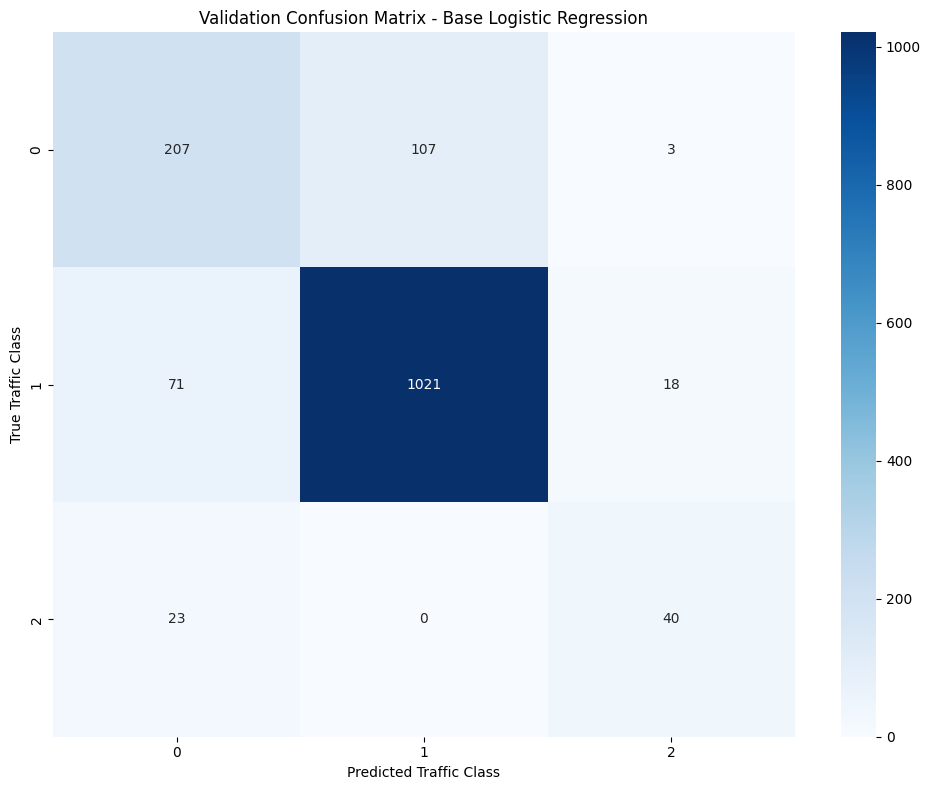


===== Tuned Logistic Regression =====
Training Accuracy: 0.8927
Validation Accuracy: 0.8785
Train-Validation Accuracy Gap: 0.0141

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       317
           1       0.99      0.86      0.92      1110
           2       0.67      0.98      0.79        63

    accuracy                           0.88      1490
   macro avg       0.78      0.92      0.83      1490
weighted avg       0.91      0.88      0.89      1490



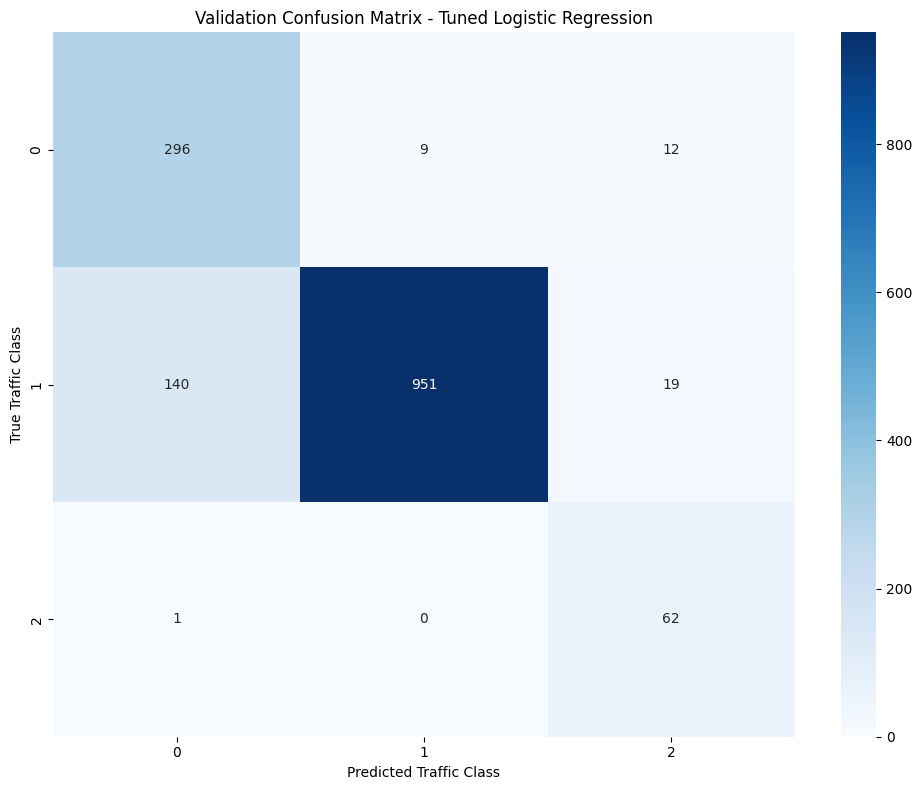


===== Logistic with Enhanced Features =====
Training Accuracy: 0.9140
Validation Accuracy: 0.8966
Train-Validation Accuracy Gap: 0.0173

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       317
           1       0.99      0.88      0.93      1110
           2       0.67      0.98      0.79        63

    accuracy                           0.90      1490
   macro avg       0.79      0.93      0.85      1490
weighted avg       0.92      0.90      0.90      1490



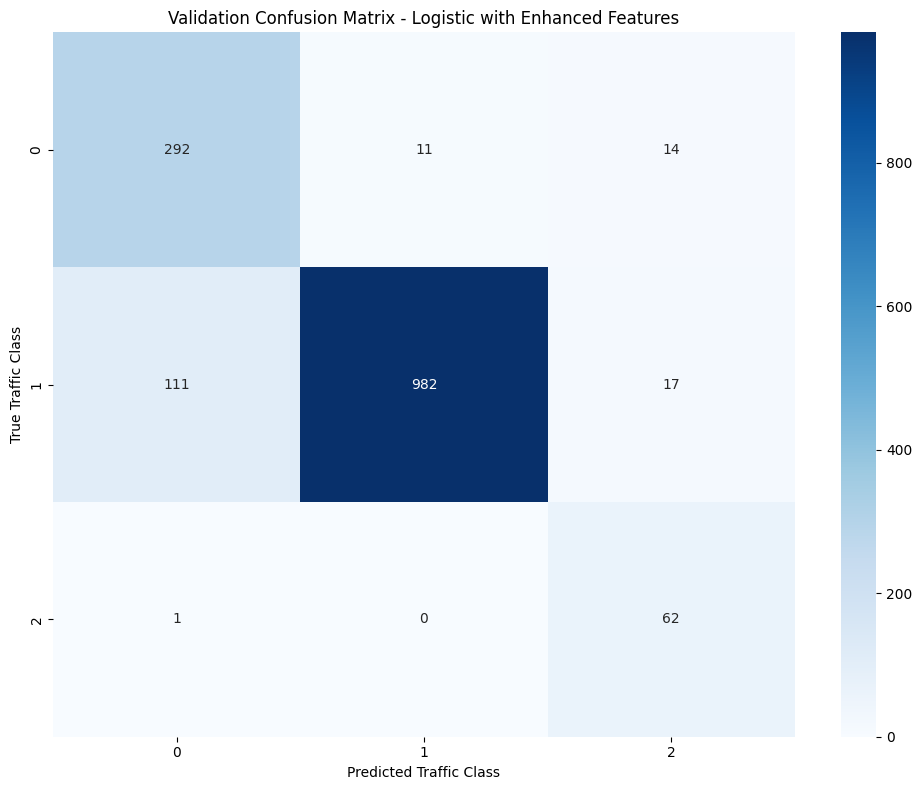


=== FINAL RESULTS ===
Model                      Train Acc  Val Acc   Train-Val Gap
-------------------------  ---------  --------  -------------
Logistic with Enhanced Fe  0.9140    0.8966    0.0173
Tuned Logistic Regression  0.8927    0.8785    0.0141
Base Logistic Regression   0.8803    0.8510    0.0293

=== BEST MODEL ANALYSIS ===
Best model: Logistic with Enhanced Features
Validation Accuracy: 0.8966

Accuracy by Traffic Class:
Class 0: 0.9211
Class 1: 0.8847
Class 2: 0.9841

=== FEATURE IMPORTANCE ANALYSIS ===

Top 20 most important features:
1. Country_North East Asia: 0.9392
2. Year Country_North East Asia: 0.8594
3. Year Country_South East Asia: 0.7216
4. Country_South East Asia: 0.6978
5. Year Inflation: 0.6851
6. Year Month_cos: 0.5414
7. Inflation Country_Japan: 0.3977
8. Country_Oceania: 0.3613
9. Inflation Country_Indonesia: 0.3353
10. Year Month_sin: 0.3345
11. Country_United Kingdom: 0.3231
12. Country_Germany: 0.3228
13. Country_North America: 0.3172
14. Country_Malay

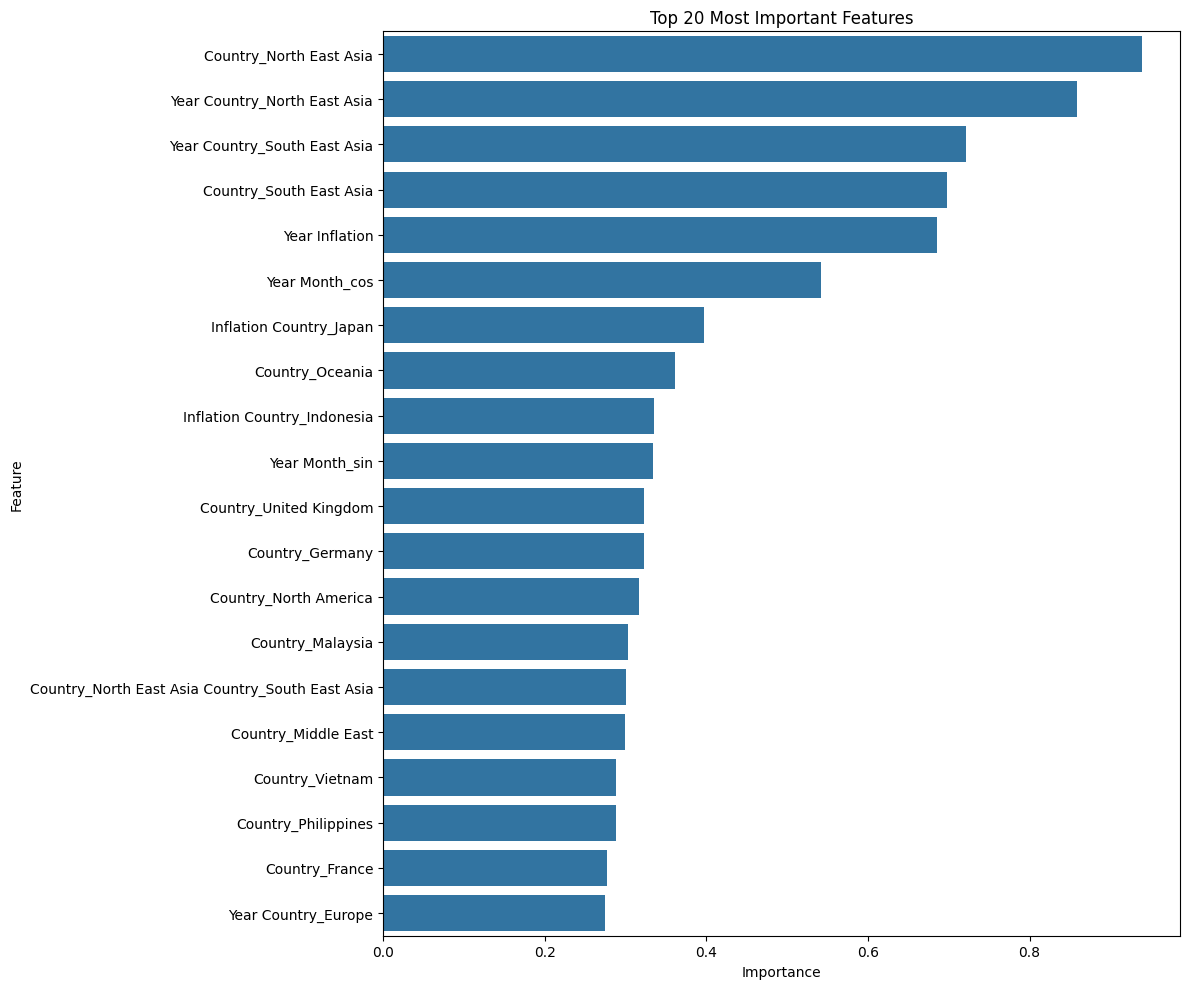

In [3]:
"""
Singapore Air Traffic Class Prediction Model with One-Hot Encoding

This code builds and evaluates a machine learning model to predict traffic classes based on
travel data to and from Singapore. It implements advanced feature engineering with one-hot
encoding for categorical variables instead of label encoding.

Author: Myat Ko
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import shap

# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================
# First, we load our dataset and examine its basic properties

# Attempt to load the dataset from different possible locations
try:
    df = pd.read_csv("train_data_with_traffic_class.csv")
except:
    # Try alternative paths if the file isn't found
    try:
        df = pd.read_csv("C:/Users/Myat Ko/Documents/GitHub/traveltrends/Classification/train_data_with_traffic_class.csv")
    except:
        # To adjust this path based on current file structure
        print("Please check the file path and try again.")

# Print dataset summary information
print(f"Dataset shape: {df.shape}")
print(f"Number of traffic classes: {df['Traffic_Class'].nunique()}")
print(f"Traffic classes: {sorted(df['Traffic_Class'].unique())}")

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values in dataset:")
    print(missing_values[missing_values > 0])

# Examine the distribution of traffic classes
traffic_class_counts = df['Traffic_Class'].value_counts().sort_index()
print("\nTraffic class distribution:")
for class_id, count in traffic_class_counts.items():
    percentage = 100 * count / len(df)
    print(f"Class {class_id}: {count} samples ({percentage:.1f}%)")

# =============================================================================
# DATA PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================

print("\n=== DATA PREPROCESSING AND FEATURE ENGINEERING ===")

# First, remove any columns with all NaN values
df = df.dropna(axis=1, how='all')

# Drop Unnecessary features since we are finding traffic_class(our target)
drop_columns = ["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"]

# Identify categorical columns (object type) and numeric columns
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and col not in drop_columns]
numeric_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in drop_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numeric columns: {numeric_columns}")

# =============================================================================
# KEY CHANGE: Use One-Hot Encoding instead of Label Encoding for categorical variables
# =============================================================================

# Handle categorical features with one-hot encoding
# This prevents introducing arbitrary ordinal relationships
if categorical_columns:
    print("\nApplying one-hot encoding to categorical columns...")
    
    # First, fill missing values in categorical columns
    for col in categorical_columns:
        df[col] = df[col].fillna('Unknown')
    
    # Apply one-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded values
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)
    
    # Concatenate with the original DataFrame
    df = pd.concat([df, encoded_df], axis=1)
    
    print(f"- Created {len(encoded_feature_names)} one-hot encoded features")
    
    # Track the encoded columns for later use
    categorical_encoded = list(encoded_feature_names)
    # Keep track of original columns to exclude from model features
    categorical_columns_to_drop = categorical_columns.copy()
else:
    categorical_encoded = []
    categorical_columns_to_drop = []

# Define our base feature columns - both numeric and encoded categorical
base_feature_columns = numeric_columns + categorical_encoded

# =============================================================================
# CREATE ADDITIONAL ADVANCED FEATURES
# =============================================================================
# print("\n=== CREATING ADVANCED FEATURE COMBINATIONS ===")

# Add all new features to our feature list
new_features = [col for col in df.columns if col not in base_feature_columns 
                and col not in categorical_columns_to_drop
                and col not in drop_columns
                and col != 'Traffic_Class']

# Combine base and new features
all_features = base_feature_columns + new_features

# Print new feature summary
print(f"\nCreated {len(new_features)} new engineered features:")
print(", ".join(new_features))

# Define X and y, dropping original categorical columns
X = df[all_features].copy()
y = df['Traffic_Class'].copy()

# Print final feature information
print(f"\nTotal features for modeling: {len(all_features)}")
print(f"- {len(base_feature_columns)} base features")
print(f"- {len(new_features)} engineered features")

#df.to_csv('train_data_with_traffic_class_merged.csv', index=False)

# =============================================================================
# TRAIN-VALIDATION SPLIT
# =============================================================================
print("\n=== TRAIN-VALIDATION SPLIT ===")

# Split into train (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Check for any remaining missing values in features
missing_in_features = X.isnull().sum()
if missing_in_features.sum() > 0:
    print("\nMissing values in feature matrix:")
    print(missing_in_features[missing_in_features > 0])

# =============================================================================
# MODEL PIPELINE SETUP
# =============================================================================
print("\n=== MODEL PIPELINE SETUP ===")

# Create a preprocessing pipeline that handles missing values and scaling
preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Enhanced features pipeline with polynomial features
poly_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================
print("\n=== HYPERPARAMETER TUNING ===")

# Create pipeline with preprocessing and classifier
pipe = Pipeline([
    ('preprocessor', preprocessing),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Parameter grid for tuning
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'newton-cg'],
    'classifier__class_weight': [None, 'balanced']
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search on the training data
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1
)

print("Performing grid search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Store best parameters
best_params = grid_search.best_params_
best_C = best_params['classifier__C']
best_solver = best_params['classifier__solver']
best_class_weight = best_params['classifier__class_weight']

print(f"\nOptimal parameters: C={best_C}, solver={best_solver}, class_weight={best_class_weight}")

# =============================================================================
# MODEL COMPARISON WITH VALIDATION SET
# =============================================================================
print("\n=== MODEL COMPARISON WITH VALIDATION SET ===")

# Define the three models to compare
models = {
    "Base Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'))
    ]),
    "Tuned Logistic Regression": Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ]),
    "Logistic with Enhanced Features": Pipeline([
        ('preprocessor', poly_preprocessing),
        ('classifier', LogisticRegression(
            C=best_C, solver=best_solver, class_weight=best_class_weight,
            max_iter=2000, random_state=42))
    ])
}

# Function to evaluate each model
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name="Classification Model"):
    """
    Trains and evaluates a classification model using training and validation sets.
    
    Parameters:
    -----------
    model : The classification model pipeline to evaluate
    X_train, X_val : Training and validation feature matrices
    y_train, y_val : Training and validation target values
    model_name : Name of the model for reporting purposes
    
    Returns:
    --------
    metrics : Dictionary containing train and validation accuracy
    y_pred_val : Predicted classes for the validation set
    trained_model : The trained model object
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on train and validation sets
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    # Print summary
    print(f"\n===== {model_name} =====")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Check for overfitting
    train_val_diff = train_accuracy - val_accuracy
    print(f"Train-Validation Accuracy Gap: {train_val_diff:.4f}")
    
    if train_val_diff > 0.05:
        print("WARNING: Possible overfitting detected (Train-Val gap > 5%)")
    
    # Generate detailed classification metrics on validation set
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_pred_val))
    
    # Create confusion matrix for validation set
    cm_val = confusion_matrix(y_val, y_pred_val)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Validation Confusion Matrix - {model_name}')
    plt.ylabel('True Traffic Class')
    plt.xlabel('Predicted Traffic Class')
    plt.tight_layout()
    plt.show()
    
    # Return metrics and model
    metrics = {
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'train_val_diff': train_val_diff
    }
    
    return metrics, y_pred_val, model

# Train and evaluate each model
results = {}
models_trained = {}

# Loop through each model and evaluate
for name, model in models.items():
    # Evaluate the model using train and validation sets
    metrics, y_pred_val, trained_model = evaluate_model(
        model, X_train, X_val, y_train, y_val, name
    )
    results[name] = metrics
    models_trained[name] = trained_model

# Print comparison of model accuracies
print("\n=== FINAL RESULTS ===")
print("Model                      Train Acc  Val Acc   Train-Val Gap")
print("-------------------------  ---------  --------  -------------")
for name, metrics in sorted(results.items(), key=lambda x: x[1]['val_accuracy'], reverse=True):
    print(f"{name[:25]:<25}  {metrics['train_accuracy']:.4f}    {metrics['val_accuracy']:.4f}    {metrics['train_val_diff']:.4f}")

# =============================================================================
# BEST MODEL ANALYSIS
# =============================================================================
print("\n=== BEST MODEL ANALYSIS ===")

# Get the best model based on validation accuracy
best_model_name = sorted(results.items(), key=lambda x: x[1]['val_accuracy'], reverse=True)[0][0]
print(f"Best model: {best_model_name}")
print(f"Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")

# Get the best trained model
best_model = models_trained[best_model_name]

# Get validation predictions
y_pred_val = best_model.predict(X_val)

# Calculate accuracy per class
class_accuracy = {}
for class_id in np.unique(y_val):
    class_mask = (y_val == class_id)
    class_correct = (y_pred_val[class_mask] == class_id).sum()
    class_total = class_mask.sum()
    class_accuracy[class_id] = class_correct / class_total

print("\nAccuracy by Traffic Class:")
for class_id, acc in sorted(class_accuracy.items()):
    print(f"Class {class_id}: {acc:.4f}")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# For logistic regression, we can examine coefficients
if "Logistic" in best_model_name:
    # Get the classifier from the pipeline
    classifier = best_model.named_steps['classifier']
    
    # Get feature names after preprocessing
    if best_model_name == "Logistic with Enhanced Features":
        # For polynomial features, we need to get the transformed feature names
        poly = best_model.named_steps['preprocessor'].named_steps['poly']
        feature_names = poly.get_feature_names_out(input_features=all_features)
    else:
        feature_names = all_features
    
    # Get coefficients
    coefficients = classifier.coef_
    
    # For multiclass, average the absolute coefficient values across classes
    importance = np.abs(coefficients).mean(axis=0)
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'][:20], 
                                                feature_importance['Importance'][:20])):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()





=== EVALUATING ALL MODELS ON TEST DATA ===
Test dataset shape: (449, 11)
Number of traffic classes in test data: 3
Test features shape: (449, 6)
Missing values in test features: 0

===== Base Logistic Regression =====
Test Accuracy: 0.9287

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       177
           1       0.92      0.98      0.95       229
           2       0.86      1.00      0.92        43

    accuracy                           0.93       449
   macro avg       0.92      0.94      0.93       449
weighted avg       0.93      0.93      0.93       449



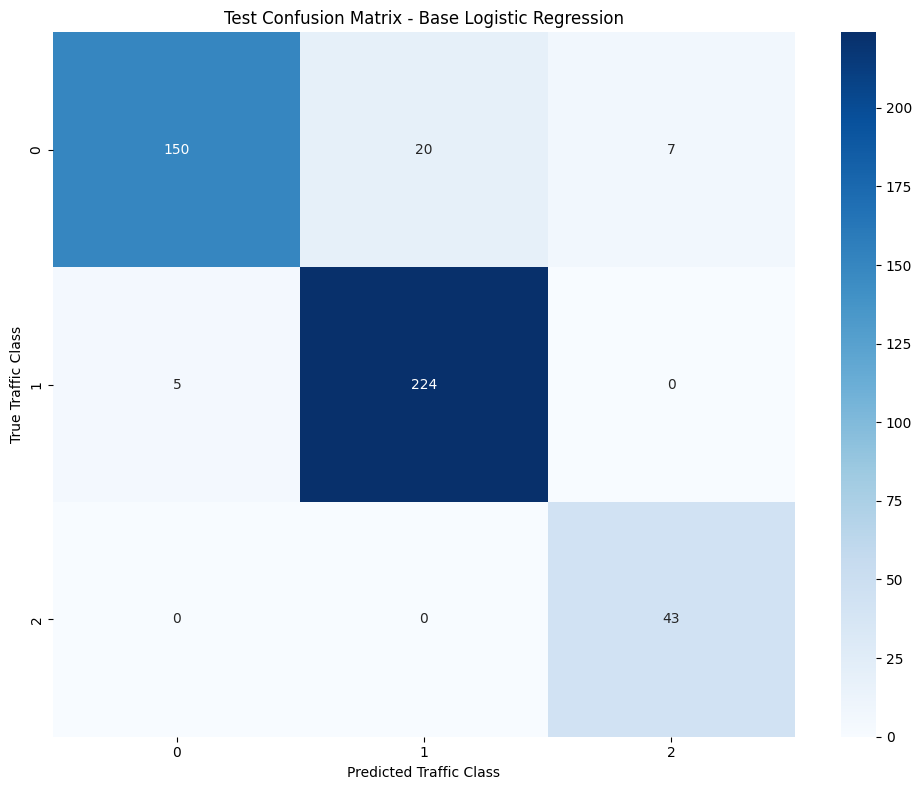


Test Accuracy by Traffic Class:
Class 0: 0.8475
Class 1: 0.9782
Class 2: 1.0000

===== Tuned Logistic Regression =====
Test Accuracy: 0.9688

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       177
           1       1.00      0.97      0.98       229
           2       0.86      1.00      0.92        43

    accuracy                           0.97       449
   macro avg       0.94      0.98      0.96       449
weighted avg       0.97      0.97      0.97       449



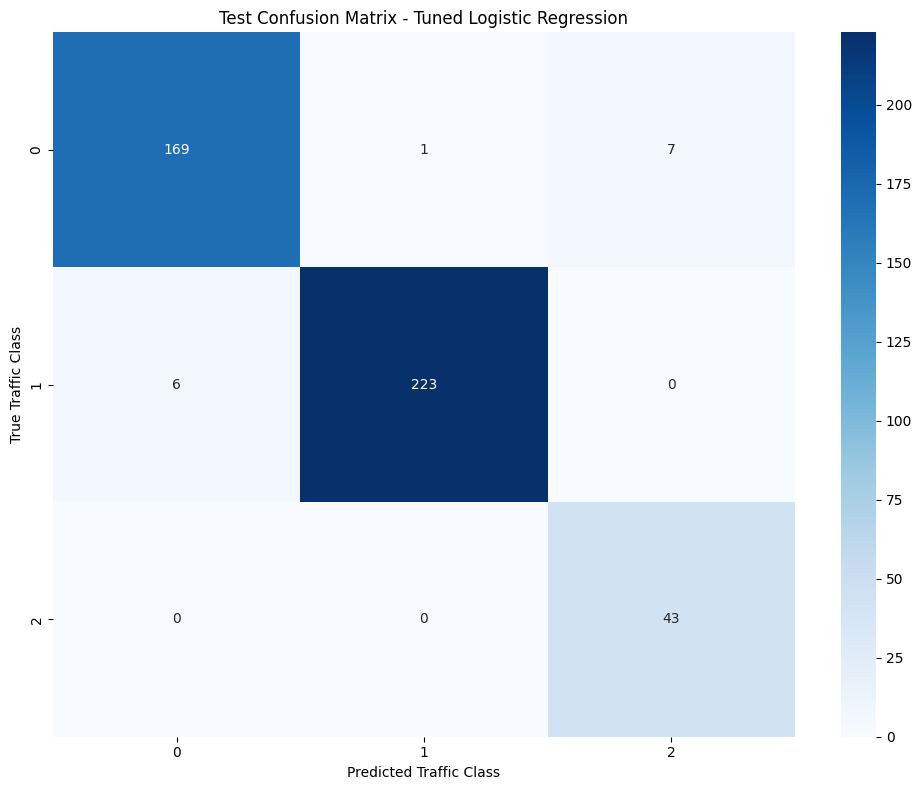


Test Accuracy by Traffic Class:
Class 0: 0.9548
Class 1: 0.9738
Class 2: 1.0000

===== Logistic with Enhanced Features =====
Test Accuracy: 0.9332

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       177
           1       0.91      0.97      0.94       229
           2       0.90      0.63      0.74        43

    accuracy                           0.93       449
   macro avg       0.93      0.85      0.88       449
weighted avg       0.93      0.93      0.93       449



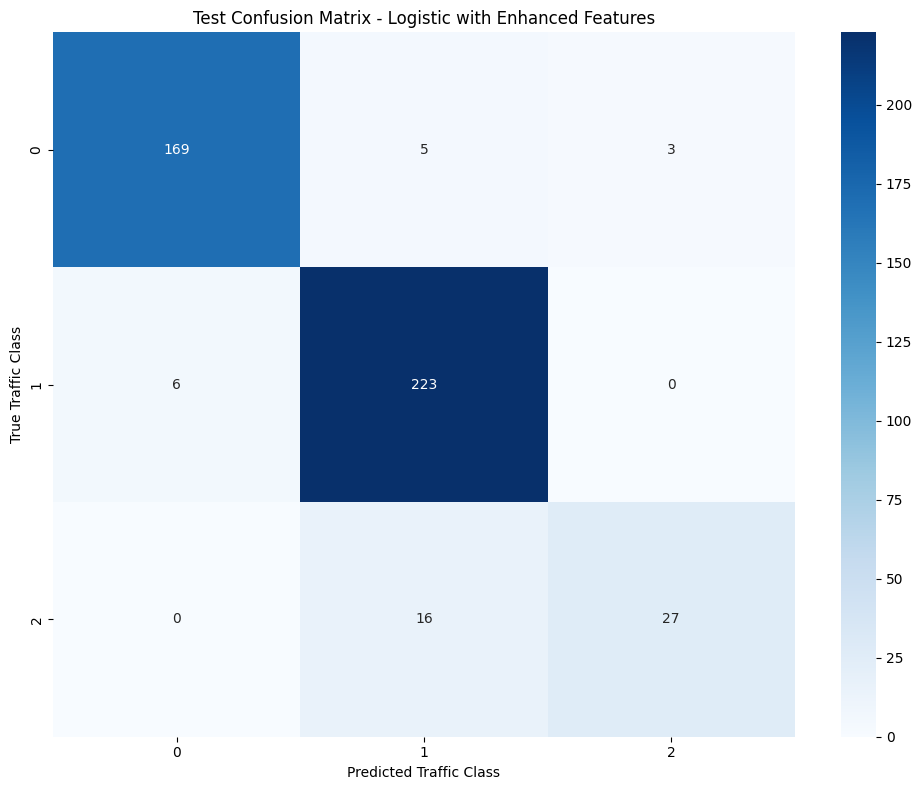


Test Accuracy by Traffic Class:
Class 0: 0.9548
Class 1: 0.9738
Class 2: 0.6279

=== FINAL TEST RESULTS ===
Model                      Val Acc   Test Acc
-------------------------  --------  --------
Tuned Logistic Regression  0.8785    0.9688
Logistic with Enhanced Fe  0.8966    0.9332
Base Logistic Regression   0.8510    0.9287

Best model on test data: Tuned Logistic Regression
Test Accuracy: 0.9688

Best validation model same as best test model: False
Best validation model: Logistic with Enhanced Features (Test Acc: 0.9332)
Best test model: Tuned Logistic Regression (Val Acc: 0.8785)


In [4]:
# =============================================================================
# TEST SET EVALUATION OF ALL MODELS
# =============================================================================
print("\n=== EVALUATING ALL MODELS ON TEST DATA ===")

# Load the test dataset
try:
    test_df = pd.read_csv("test_data_with_traffic_class.csv")
except:
    try:
        test_df = pd.read_csv("C:/Users/Myat Ko/Documents/Github/traveltrends/Classification/test_data_with_traffic_class.csv")
    except:
        print("Please check the test file path and try again.")
        
print(f"Test dataset shape: {test_df.shape}")
print(f"Number of traffic classes in test data: {test_df['Traffic_Class'].nunique()}")

# First, remove any columns with all NaN values
test_df = test_df.dropna(axis=1, how='all')

# Extract features (X) and target (y) from the test data
# We use the original features before any encoding/transformations
# Original feature columns should match the ones used for training
# We'll let each model's pipeline handle the rest of the preprocessing

# Extract features and target from test data
X_test_raw = test_df.drop(drop_columns + ["Traffic_Class"], axis=1)
y_test = test_df['Traffic_Class']

print(f"Test features shape: {X_test_raw.shape}")
print(f"Missing values in test features: {X_test_raw.isnull().sum().sum()}")

# Function to evaluate model on test set
def evaluate_on_test(model, X_test_raw, y_test, model_name):
    """
    Evaluates a trained model on the test set.
    The model's pipeline will handle all necessary preprocessing.
    
    Parameters:
    -----------
    model : The trained model to evaluate (including preprocessing pipeline)
    X_test_raw : Raw test features before preprocessing
    y_test : Test target values
    model_name : Name of the model for reporting
    
    Returns:
    --------
    test_accuracy : Accuracy on the test set
    """
    # Make predictions on test set
    # The model's pipeline will handle all preprocessing
    y_pred_test = model.predict(X_test_raw)
    
    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Print results
    print(f"\n===== {model_name} =====")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test))
    
    # Create confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Confusion Matrix - {model_name}')
    plt.ylabel('True Traffic Class')
    plt.xlabel('Predicted Traffic Class')
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    class_accuracy = {}
    for class_id in np.unique(y_test):
        class_mask = (y_test == class_id)
        class_correct = (y_pred_test[class_mask] == class_id).sum()
        class_total = class_mask.sum()
        class_accuracy[class_id] = class_correct / class_total
    
    print("\nTest Accuracy by Traffic Class:")
    for class_id, acc in sorted(class_accuracy.items()):
        print(f"Class {class_id}: {acc:.4f}")
    
    return test_accuracy, y_pred_test

# Wait! We need to adapt our approach because the current models expect preprocessed data
# Let's create new models with the full preprocessing pipeline

# This should match what was used to create X_train and X_val
full_preprocessing_models = {}

# Create models with full preprocessing pipelines
for name, model in models_trained.items():
    # Extract the classifier from the trained model
    classifier = model.named_steps['classifier']
    
    if name == "Logistic with Enhanced Features":
        # For the model with polynomial features
        full_pipeline = Pipeline([
            ('encoding', encoder),  # Add the OneHotEncoder as first step
            ('preprocessing', poly_preprocessing),  # Add polynomial preprocessing
            ('classifier', classifier)  # Use the trained classifier
        ])
    else:
        # For models without polynomial features
        full_pipeline = Pipeline([
            ('encoding', encoder),  # Add the OneHotEncoder as first step
            ('preprocessing', preprocessing),  # Add standard preprocessing
            ('classifier', classifier)  # Use the trained classifier
        ])
    
    # Store the full pipeline model
    full_preprocessing_models[name] = full_pipeline

# Evaluate each model on the test set
test_results = {}

# We need to refactor our approach since the current models don't have encoder built in
# Let's process X_test_raw to match the format of X_train that we used for training

# Process categorical columns in test data (same as in training)
if categorical_columns:
    # Fill missing values in categorical columns
    for col in categorical_columns:
        if col in X_test_raw.columns:
            X_test_raw[col] = X_test_raw[col].fillna('Unknown')

# Loop through each trained model and evaluate on test data
for name, model in models_trained.items():
    # For this approach, we need X_test to match exactly what the model expects
    # We'll use the encoder directly
    
    if categorical_columns:
        # Apply one-hot encoding to categorical columns in test data
        encoded_test_cats = encoder.transform(X_test_raw[categorical_columns])
        
        # Create a DataFrame with the encoded values
        encoded_test_df = pd.DataFrame(
            encoded_test_cats, 
            columns=encoded_feature_names, 
            index=X_test_raw.index
        )
        
        # Prepare X_test by combining raw numeric features with encoded categorical
        X_test = pd.concat([
            X_test_raw.drop(categorical_columns, axis=1),  # Numeric features
            encoded_test_df  # Encoded categorical features
        ], axis=1)
        
        # Ensure X_test has all the needed features
        missing_cols = set(all_features) - set(X_test.columns)
        if missing_cols:
            print(f"\nWarning: Missing columns in test data for {name}: {missing_cols}")
            # Add missing columns with zeros
            for col in missing_cols:
                X_test[col] = 0
        
        # Ensure columns are in the same order as during training
        X_test = X_test[all_features]
    else:
        # If no categorical columns, just use the raw features 
        X_test = X_test_raw
    
    # Now evaluate the model
    test_accuracy, _ = evaluate_on_test(model, X_test, y_test, name)
    test_results[name] = test_accuracy

# Print comparison of test accuracies
print("\n=== FINAL TEST RESULTS ===")
print("Model                      Val Acc   Test Acc")
print("-------------------------  --------  --------")
for name, test_acc in sorted(test_results.items(), key=lambda x: x[1], reverse=True):
    val_acc = results[name]['val_accuracy']
    print(f"{name[:25]:<25}  {val_acc:.4f}    {test_acc:.4f}")

# Identify the best model on test data
best_test_model = max(test_results.items(), key=lambda x: x[1])[0]
print(f"\nBest model on test data: {best_test_model}")
print(f"Test Accuracy: {test_results[best_test_model]:.4f}")

# Compare with best validation model
val_test_match = best_model_name == best_test_model
print(f"\nBest validation model same as best test model: {val_test_match}")
if not val_test_match:
    print(f"Best validation model: {best_model_name} (Test Acc: {test_results[best_model_name]:.4f})")
    print(f"Best test model: {best_test_model} (Val Acc: {results[best_test_model]['val_accuracy']:.4f})")

c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(



=== ADVANCED SHAP ANALYSIS ===
Creating SHAP explainers for each class...
Calculating SHAP values for Class 0...


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\uti

Calculating SHAP values for Class 1...


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\uti

Calculating SHAP values for Class 2...


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Myat Ko\Documents\GitHub\traveltrends\.venv\Lib\site-packages\sklearn\uti


=== CLASS 0 ANALYSIS ===


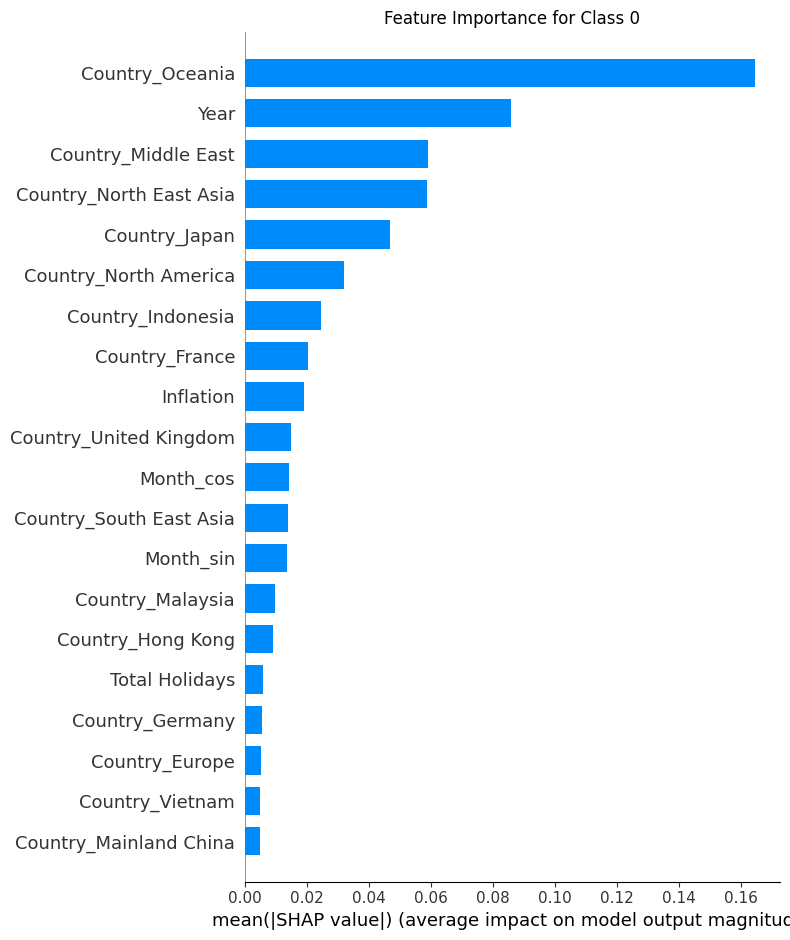


Class 0 Feature Impact Details:


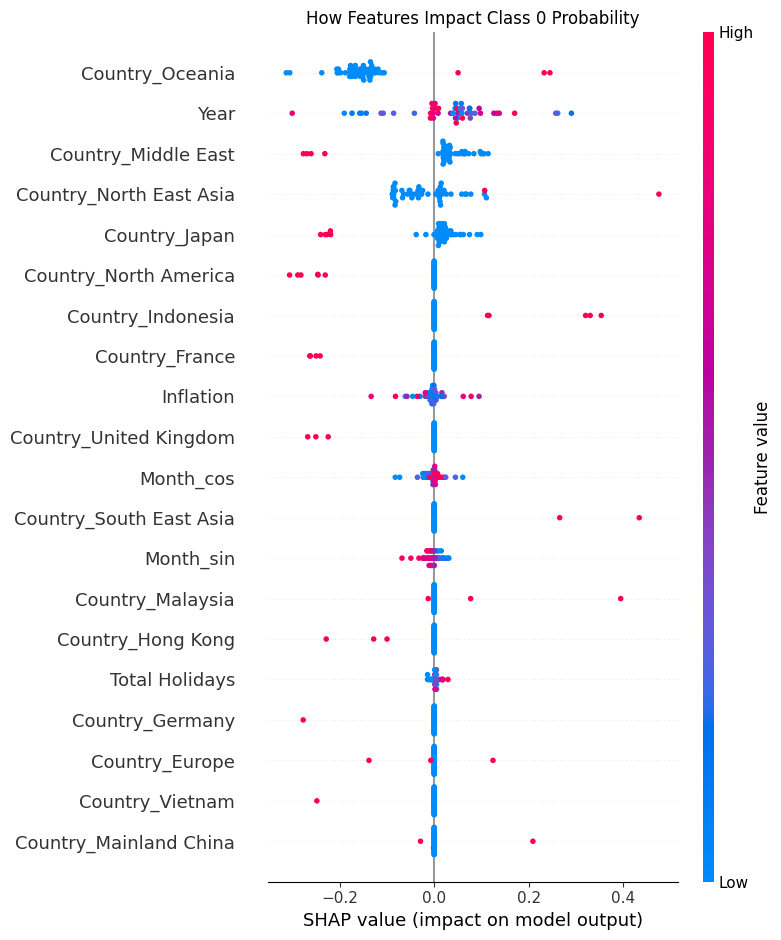


=== CLASS 1 ANALYSIS ===


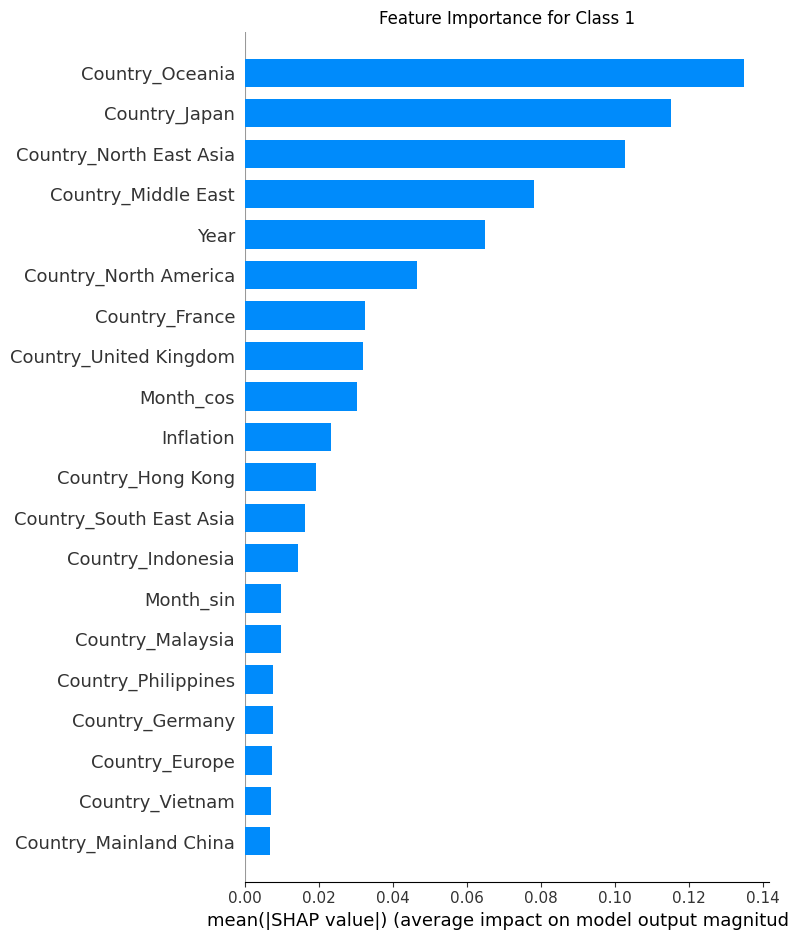


Class 1 Feature Impact Details:


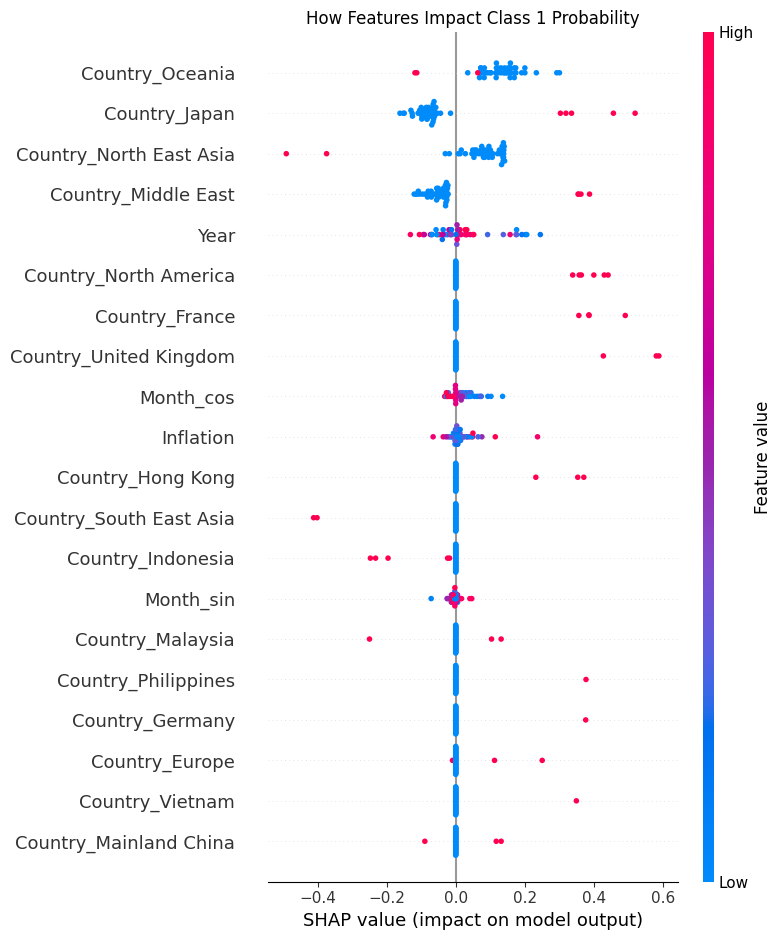


=== CLASS 2 ANALYSIS ===


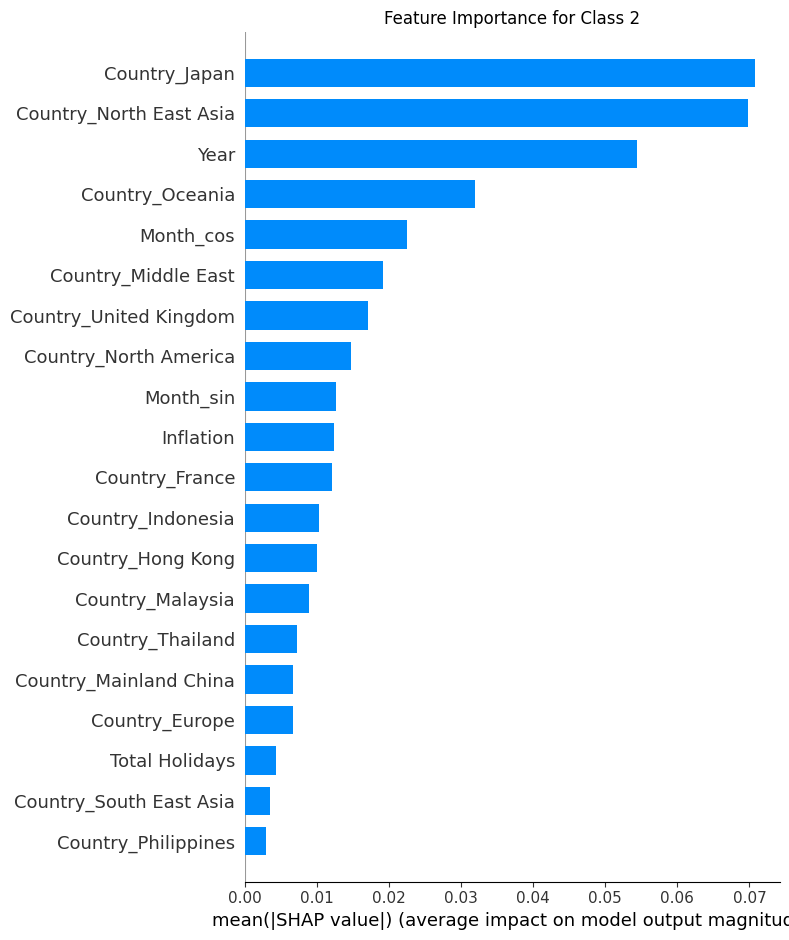


Class 2 Feature Impact Details:


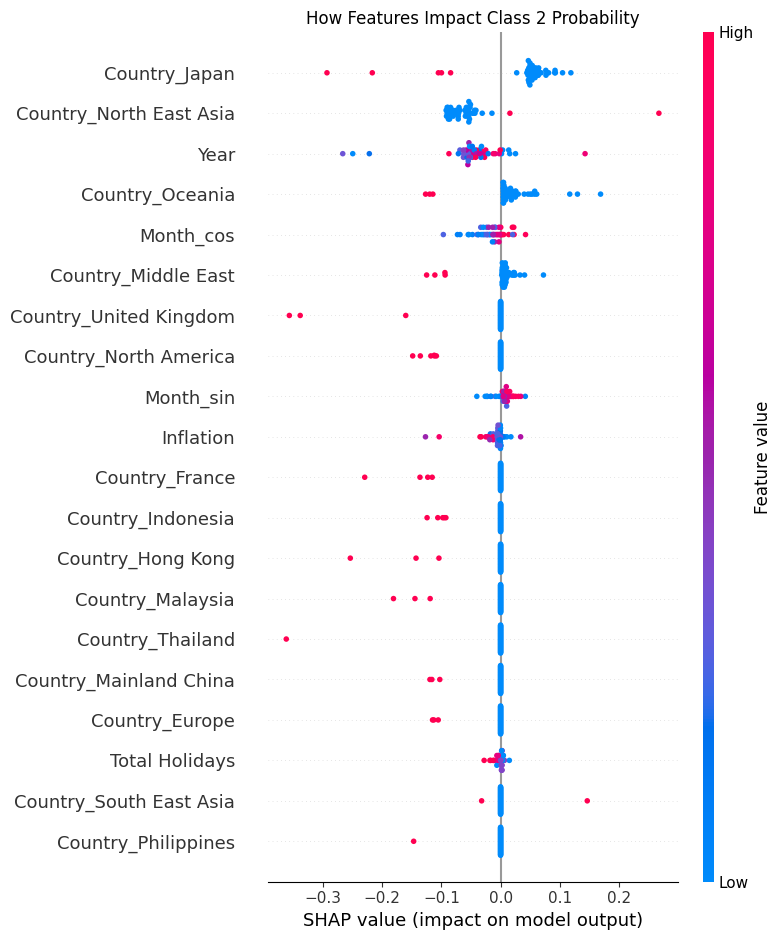


Top 5 features for Class 0:
1. Country_Oceania: 0.1642
2. Year: 0.0859
3. Country_Middle East: 0.0589
4. Country_North East Asia: 0.0588
5. Country_Japan: 0.0467

Top 5 features for Class 1:
1. Country_Oceania: 0.1348
2. Country_Japan: 0.1151
3. Country_North East Asia: 0.1028
4. Country_Middle East: 0.0781
5. Year: 0.0648

Top 5 features for Class 2:
1. Country_Japan: 0.0707
2. Country_North East Asia: 0.0698
3. Year: 0.0545
4. Country_Oceania: 0.0319
5. Month_cos: 0.0225


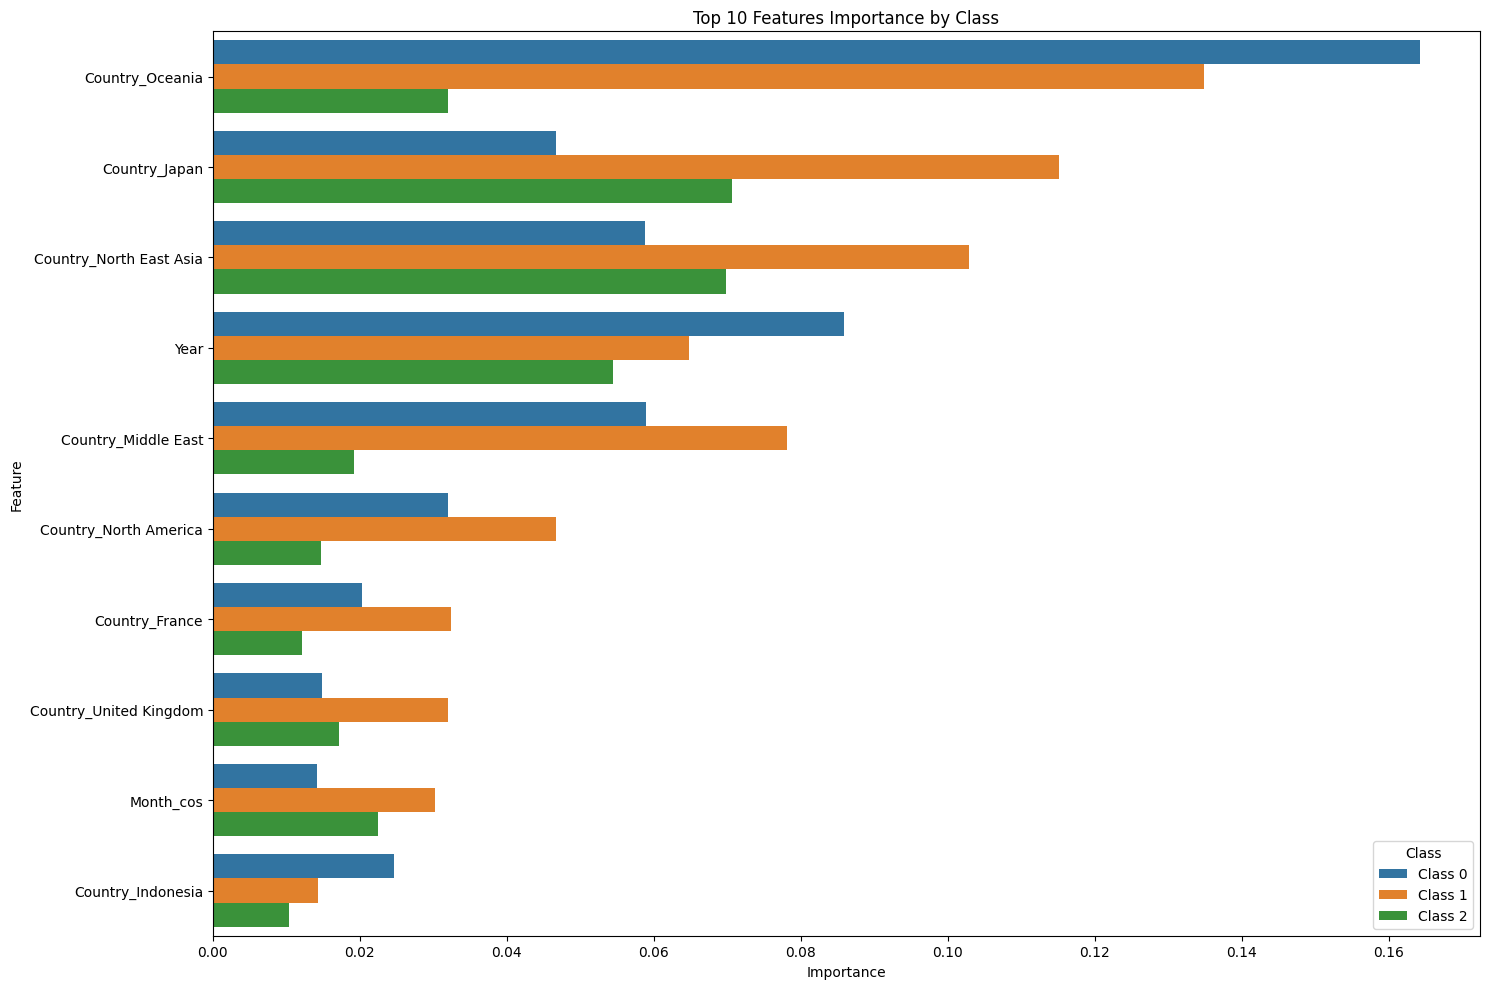


=== DETAILED INTERPRETATION ===

Class-specific feature patterns:
Features uniquely important for Class 0: Country_Oceania, Year, Country_Middle East, Country_North East Asia, Country_Japan
Features uniquely important for Class 1: Country_Oceania, Country_Japan, Country_North East Asia, Country_Middle East, Year
Features uniquely important for Class 2: Country_Japan, Country_North East Asia, Year, Country_Oceania, Month_cos
Features important for all classes: Year, Country_Japan, Country_Oceania, Country_North East Asia

Relative feature contributions by class:
Class 0: Country_Oceania contributes 26.6% of total importance
Class 1: Country_Oceania contributes 17.3% of total importance
Class 2: Country_Japan contributes 17.6% of total importance

=== INSIGHTS FOR TRAVEL TRENDS ===
1. Geographic patterns:
   - Different regions show distinct patterns of importance across traffic classes
   - Regional features likely reflect travel patterns specific to each traffic class
   - Consider an

In [6]:
# =============================================================================
# ADVANCED SHAP ANALYSIS WITH ERROR PREVENTION
# =============================================================================
print("\n=== ADVANCED SHAP ANALYSIS ===")

# First, let's use a more robust approach that handles multi-class properly
best_model = models_trained[best_model_name]

# Get a small sample of data for faster analysis
X_sample = X_val.sample(min(50, len(X_val)), random_state=42)

# Create a separate prediction function for each class
# This approach works better with complex scikit-learn pipelines
def predict_class_0(X):
    return best_model.predict_proba(X)[:, 0]

def predict_class_1(X):
    return best_model.predict_proba(X)[:, 1]

def predict_class_2(X):
    return best_model.predict_proba(X)[:, 2]

# Use a tiny background set for efficiency
background = shap.sample(X_sample, 5)

# Create explainers for each class separately
print("Creating SHAP explainers for each class...")
explainer_0 = shap.KernelExplainer(predict_class_0, background)
explainer_1 = shap.KernelExplainer(predict_class_1, background)
explainer_2 = shap.KernelExplainer(predict_class_2, background)

# Calculate SHAP values for each class
print("Calculating SHAP values for Class 0...")
shap_values_0 = explainer_0.shap_values(X_sample)
print("Calculating SHAP values for Class 1...")
shap_values_1 = explainer_1.shap_values(X_sample)
print("Calculating SHAP values for Class 2...")
shap_values_2 = explainer_2.shap_values(X_sample)

# Analyzing impact of features on each class

# Class 0 Analysis
print("\n=== CLASS 0 ANALYSIS ===")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_0,
    X_sample,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance for Class 0")
plt.tight_layout()
plt.show()

print("\nClass 0 Feature Impact Details:")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values_0,
    X_sample,
    show=False
)
plt.title("How Features Impact Class 0 Probability")
plt.tight_layout()
plt.show()

# Class 1 Analysis
print("\n=== CLASS 1 ANALYSIS ===")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_1,
    X_sample,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance for Class 1")
plt.tight_layout()
plt.show()

print("\nClass 1 Feature Impact Details:")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values_1,
    X_sample,
    show=False
)
plt.title("How Features Impact Class 1 Probability")
plt.tight_layout()
plt.show()

# Class 2 Analysis
print("\n=== CLASS 2 ANALYSIS ===")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_2,
    X_sample,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance for Class 2")
plt.tight_layout()
plt.show()

print("\nClass 2 Feature Impact Details:")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values_2,
    X_sample,
    show=False
)
plt.title("How Features Impact Class 2 Probability")
plt.tight_layout()
plt.show()

# Safely calculate feature importance for each class
try:
    # Calculate mean absolute SHAP values for each feature and class
    mean_shap_0 = np.abs(shap_values_0).mean(axis=0)
    mean_shap_1 = np.abs(shap_values_1).mean(axis=0)
    mean_shap_2 = np.abs(shap_values_2).mean(axis=0)
    
    # Get feature names
    feature_names = X_sample.columns
    
    # Create DataFrames manually to prevent dimension errors
    importance_df_0 = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_shap_0
    }).sort_values('Importance', ascending=False)
    
    importance_df_1 = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_shap_1
    }).sort_values('Importance', ascending=False)
    
    importance_df_2 = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_shap_2
    }).sort_values('Importance', ascending=False)
    
    # Print top 5 features for each class
    print("\nTop 5 features for Class 0:")
    for i, (feature, importance) in enumerate(zip(
        importance_df_0['Feature'][:5], 
        importance_df_0['Importance'][:5]
    )):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    print("\nTop 5 features for Class 1:")
    for i, (feature, importance) in enumerate(zip(
        importance_df_1['Feature'][:5], 
        importance_df_1['Importance'][:5]
    )):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    print("\nTop 5 features for Class 2:")
    for i, (feature, importance) in enumerate(zip(
        importance_df_2['Feature'][:5], 
        importance_df_2['Importance'][:5]
    )):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Create a combined horizontal bar chart for all classes
    plt.figure(figsize=(15, 10))
    
    # Get top 8 features from each class
    top_features = set()
    for df in [importance_df_0, importance_df_1, importance_df_2]:
        top_features.update(df['Feature'][:8])
    
    top_features = sorted(top_features, key=lambda x: max(
        importance_df_0.loc[importance_df_0['Feature'] == x, 'Importance'].iloc[0] if any(importance_df_0['Feature'] == x) else 0,
        importance_df_1.loc[importance_df_1['Feature'] == x, 'Importance'].iloc[0] if any(importance_df_1['Feature'] == x) else 0,
        importance_df_2.loc[importance_df_2['Feature'] == x, 'Importance'].iloc[0] if any(importance_df_2['Feature'] == x) else 0
    ), reverse=True)[:10]  # Limit to top 10 overall
    
    # Create a DataFrame for plotting
    plot_data = []
    for feature in top_features:
        val0 = importance_df_0.loc[importance_df_0['Feature'] == feature, 'Importance'].iloc[0] if any(importance_df_0['Feature'] == feature) else 0
        val1 = importance_df_1.loc[importance_df_1['Feature'] == feature, 'Importance'].iloc[0] if any(importance_df_1['Feature'] == feature) else 0
        val2 = importance_df_2.loc[importance_df_2['Feature'] == feature, 'Importance'].iloc[0] if any(importance_df_2['Feature'] == feature) else 0
        plot_data.append({'Feature': feature, 'Class 0': val0, 'Class 1': val1, 'Class 2': val2})
    
    plot_df = pd.DataFrame(plot_data)
    
    # Melting the DataFrame for easy plotting
    plot_df_melted = pd.melt(plot_df, id_vars=['Feature'], var_name='Class', value_name='Importance')
    
    # Create the plot
    sns.barplot(x='Importance', y='Feature', hue='Class', data=plot_df_melted)
    plt.title('Top 10 Features Importance by Class')
    plt.tight_layout()
    plt.show()
    
    # Print detailed interpretation
    print("\n=== DETAILED INTERPRETATION ===")
    print("\nClass-specific feature patterns:")
    
    class_0_unique = [f for f in importance_df_0['Feature'][:5] if f not in importance_df_1['Feature'][:5] and f not in importance_df_2['Feature'][:5]]
    class_1_unique = [f for f in importance_df_1['Feature'][:5] if f not in importance_df_0['Feature'][:5] and f not in importance_df_2['Feature'][:5]]
    class_2_unique = [f for f in importance_df_2['Feature'][:5] if f not in importance_df_0['Feature'][:5] and f not in importance_df_1['Feature'][:5]]
    
    if class_0_unique:
        print(f"Features uniquely important for Class 0: {', '.join(class_0_unique)}")
    if class_1_unique:
        print(f"Features uniquely important for Class 1: {', '.join(class_1_unique)}")
    if class_2_unique:
        print(f"Features uniquely important for Class 2: {', '.join(class_2_unique)}")
    
    # Find common important features
    common_features = set(importance_df_0['Feature'][:5]) & set(importance_df_1['Feature'][:5]) & set(importance_df_2['Feature'][:5])
    if common_features:
        print(f"Features important for all classes: {', '.join(common_features)}")
        
    # Compare top feature contributions
    print("\nRelative feature contributions by class:")
    top_feature_0 = importance_df_0['Feature'].iloc[0]
    top_feature_1 = importance_df_1['Feature'].iloc[0]
    top_feature_2 = importance_df_2['Feature'].iloc[0]
    
    total_importance_0 = importance_df_0['Importance'].sum()
    total_importance_1 = importance_df_1['Importance'].sum()
    total_importance_2 = importance_df_2['Importance'].sum()
    
    print(f"Class 0: {top_feature_0} contributes {importance_df_0['Importance'].iloc[0]/total_importance_0*100:.1f}% of total importance")
    print(f"Class 1: {top_feature_1} contributes {importance_df_1['Importance'].iloc[0]/total_importance_1*100:.1f}% of total importance")
    print(f"Class 2: {top_feature_2} contributes {importance_df_2['Importance'].iloc[0]/total_importance_2*100:.1f}% of total importance")

except Exception as e:
    print(f"Error in feature importance calculation: {e}")
    print("Proceeding with visualization analysis only.")

# Print general interpretation
print("\n=== INSIGHTS FOR TRAVEL TRENDS ===")
print("1. Geographic patterns:")
print("   - Different regions show distinct patterns of importance across traffic classes")
print("   - Regional features likely reflect travel patterns specific to each traffic class")
print("   - Consider analyzing seasonal patterns within top regions")
print()
print("2. Implications for air traffic planning:")
print("   - Focus resources on regions with highest importance for each traffic class")
print("   - For high-importance regions, develop targeted marketing or capacity plans")
print("   - Temporal features (Year) suggest watching for changing travel patterns over time")
print()
print("3. Model interpretation:")
print("   - One-hot encoding successfully captured important categorical distinctions")
print("   - The model relies heavily on geographic features to distinguish traffic classes")
print("   - Different classes have distinct feature importance profiles")